# Onboard a Doctor in Training
## Role: Lead Employer

The lead employer is responsible for verifying GMC licences and issuing credentials needed by new doctors before they can begin specific placements. These include; dbs checks, mandatory training, occupational health and assigment credentials.

## Before running through this notebook you should run through the following notebook - [Part 5.1](http://localhost:8892/notebooks/Part%205.1%20-%20Initialising%20the%20Lead%20Employer%20Agent.ipynb).

## Or alternatively you can start at the beginning of the Doctors in Training flow [here](http://localhost:8889/notebooks/Part%201%20-%20Getting%20Started.ipynb).



## 1. Initialise a controller for the Lead Employer

In [23]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8062
WEBHOOK_BASE = ""
ADMIN_URL = "http://lead-employer-agent:8061"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [24]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scans this QR code and then can communicate with the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

You must have a ssi wallet installed on your phone and connected to the Sovrin StagingNet for this to work.

### 3.1 Generate an invitation

In [44]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'connection_id': '904abee2-ccef-417f-aa3f-6078debfa38a', 'invitation_mode': 'once', 'routing_state': 'none', 'initiator': 'self', 'accept': 'auto', 'created_at': '2020-09-22 12:01:27.838775Z', 'updated_at': '2020-09-22 12:01:27.838775Z', 'invitation_key': 'EbDWBhop5HSi4zgmfAVBnKDqUoUnapi8up9mw1twuTwx', 'state': 'invitation'} 904abee2-ccef-417f-aa3f-6078debfa38a
Connection ID 904abee2-ccef-417f-aa3f-6078debfa38a
Invitation
https://de4cac5a6fe8.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiNzZjNjFlODAtMzFiNi00ZTg3LWE0MjUtZjFlMjlkOTQ4NmYwIiwgInJlY2lwaWVudEtleXMiOiBbIkViRFdCaG9wNUhTaTR6Z21mQVZCbktEcVVvVW5hcGk4dXA5bXcxdHd1VHd4Il0sICJsYWJlbCI6ICJOSFMgTGVhZCBFbXBsb3llciIsICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cHM6Ly9kZTRjYWM1YTZmZTgubmdyb2suaW8ifQ==


### 3.2 Display as QrCode to be Scanned by SSI Wallet

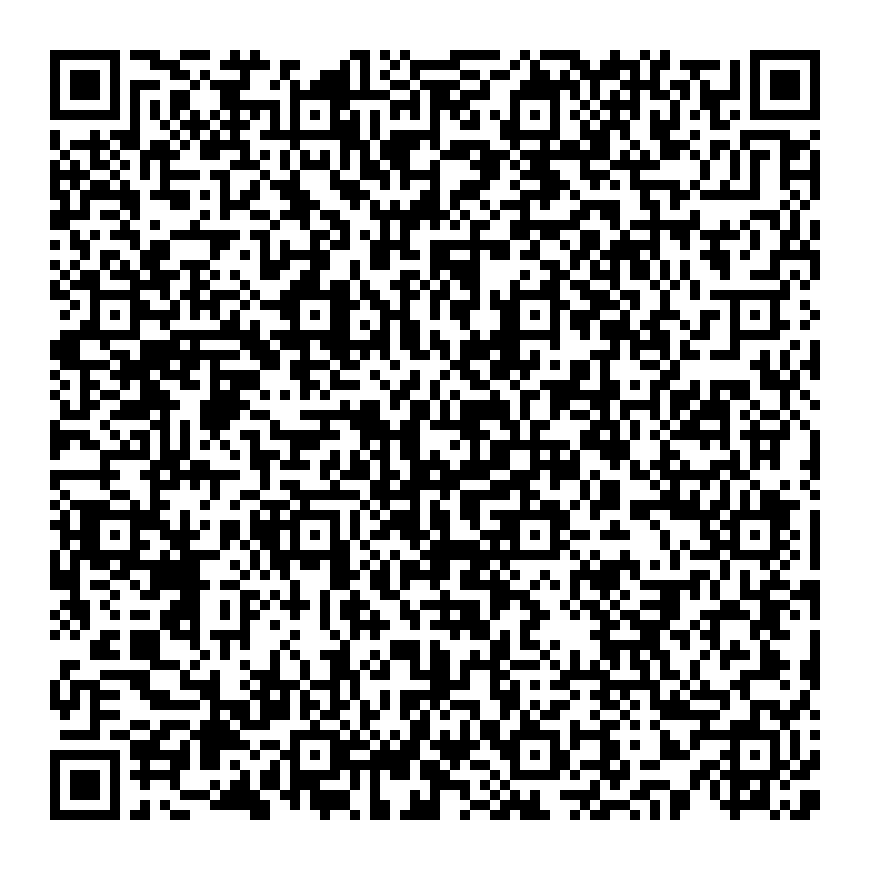

Connection message {'connection_id': '904abee2-ccef-417f-aa3f-6078debfa38a', 'invitation_mode': 'once', 'routing_state': 'none', 'initiator': 'self', 'accept': 'auto', 'created_at': '2020-09-22 12:01:27.838775Z', 'their_label': 'esatus Wallet', 'their_did': 'RDUvqCC5pbPnQ3Ym4jYFDu', 'updated_at': '2020-09-22 12:01:36.874968Z', 'invitation_key': 'EbDWBhop5HSi4zgmfAVBnKDqUoUnapi8up9mw1twuTwx', 'state': 'request'} 904abee2-ccef-417f-aa3f-6078debfa38a
Connection message {'connection_id': '904abee2-ccef-417f-aa3f-6078debfa38a', 'invitation_mode': 'once', 'routing_state': 'none', 'initiator': 'self', 'accept': 'auto', 'created_at': '2020-09-22 12:01:27.838775Z', 'their_label': 'esatus Wallet', 'their_did': 'RDUvqCC5pbPnQ3Ym4jYFDu', 'updated_at': '2020-09-22 12:01:36.904189Z', 'my_did': 'LhHB2Fz4WHbc7DBgvh995L', 'invitation_key': 'EbDWBhop5HSi4zgmfAVBnKDqUoUnapi8up9mw1twuTwx', 'state': 'response'} 904abee2-ccef-417f-aa3f-6078debfa38a


In [45]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)

qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

### 3.3 Check the connection is in the active state

In [46]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 904abee2-ccef-417f-aa3f-6078debfa38a is response
ConnectionId 904abee2-ccef-417f-aa3f-6078debfa38a is not in active state yet
Trust ping send to ConnectionId {'thread_id': '5a48303b-6218-48c8-af55-eb34dcbfa437'} to activate connection
ConnectionId 904abee2-ccef-417f-aa3f-6078debfa38a is not in active state yet
Connection message {'connection_id': '904abee2-ccef-417f-aa3f-6078debfa38a', 'invitation_mode': 'once', 'routing_state': 'none', 'initiator': 'self', 'accept': 'auto', 'created_at': '2020-09-22 12:01:27.838775Z', 'their_label': 'esatus Wallet', 'their_did': 'RDUvqCC5pbPnQ3Ym4jYFDu', 'updated_at': '2020-09-22 12:01:43.393329Z', 'my_did': 'LhHB2Fz4WHbc7DBgvh995L', 'invitation_key': 'EbDWBhop5HSi4zgmfAVBnKDqUoUnapi8up9mw1twuTwx', 'state': 'active'} 904abee2-ccef-417f-aa3f-6078debfa38a
Connection 904abee2-ccef-417f-aa3f-6078debfa38a changed state to active
Trust ping send to ConnectionId {'thread_id': 'd8187e1d-e8b5-4e38-8bee-688f48e24f3a'} to activate 

## 4. Request Proof Presentation

## 5a. Generate proof request

In [47]:
print("Request proof of Passport information")

#Set some variables

REVOCATION = False
SELF_ATTESTED = False
EXCHANGE_TRACING = False

req_attrs = [
    {"name": "PSS Given Names", "restrictions": []},
    {"name": "PSS Surname", "restrictions": []},
    {"name": "PSS Sex", "restrictions": []},
    {"name": "PSS Place of Birth", "restrictions": []},
    {"name": "PSS Date of Birth", "restrictions": []},
]

if REVOCATION:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"schema_id": schema_id}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = []

indy_proof_request = {
    "name": "Proof of Passport Credential",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if REVOCATION:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = EXCHANGE_TRACING
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": EXCHANGE_TRACING,
}

Request proof of Passport information


### 5b. Send the proof request to Doctor

Doctor is identified through the connection_id

In [54]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)


{'connection_id': '904abee2-ccef-417f-aa3f-6078debfa38a', 'role': 'verifier', 'auto_present': False, 'initiator': 'self', 'created_at': '2020-09-22 12:03:59.293582Z', 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': '036532f9-e871-40bf-852a-6f5ba67a237c', 'request_presentations~attach': [{'@id': 'libindy-request-presentation-0', 'mime-type': 'application/json', 'data': {'base64': 'eyJuYW1lIjogIlByb29mIG9mIFBhc3Nwb3J0IENyZWRlbnRpYWwiLCAidmVyc2lvbiI6ICIxLjAiLCAicmVxdWVzdGVkX2F0dHJpYnV0ZXMiOiB7IjBfUFNTIEdpdmVuIE5hbWVzX3V1aWQiOiB7Im5hbWUiOiAiUFNTIEdpdmVuIE5hbWVzIiwgInJlc3RyaWN0aW9ucyI6IFtdfSwgIjBfUFNTIFN1cm5hbWVfdXVpZCI6IHsibmFtZSI6ICJQU1MgU3VybmFtZSIsICJyZXN0cmljdGlvbnMiOiBbXX0sICIwX1BTUyBTZXhfdXVpZCI6IHsibmFtZSI6ICJQU1MgU2V4IiwgInJlc3RyaWN0aW9ucyI6IFtdfSwgIjBfUFNTIFBsYWNlIG9mIEJpcnRoX3V1aWQiOiB7Im5hbWUiOiAiUFNTIFBsYWNlIG9mIEJpcnRoIiwgInJlc3RyaWN0aW9ucyI6IFtdfSwgIjBfUFNTIERhdGUgb2YgQmlydGhfdXVpZCI6IHsibmFtZSI6ICJQU

## 5c. Verify proof presentation and populate credential template

This is checking the signatures on the credentials presented against the credential schema and definition id stored and resolvable on the ledger. It is a bit of a big complicated object, so we show the common pattern for breaking it down, checking it's verified and accessing the data that has been presented.

In [49]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)

# print proof request verification status
print('Proof request state verified?: {} '.format(verify['state'] == 'verified'))


Proof request state verified?: True 


In [57]:
print(verify['presentation']['requested_proof']['self_attested_attrs'])

{'0_PSS Given Names_uuid': 'Peter', '0_PSS Place of Birth_uuid': 'ZA', '0_PSS Date of Birth_uuid': '2020-01-01', '0_PSS Sex_uuid': 'M', '0_PSS Surname_uuid': 'Pan'}


In [66]:
# access the revealed attributes and populate credential
credential_attributes = []
if len(verify['presentation']['requested_proof']['revealed_attrs']) > 0:
    for (name, val) in verify['presentation']['requested_proof']['revealed_attrs'].items():
        ## This is the actual data that you want. It's a little hidden
        print('Atribute name: {} Value: {}'.format(name,val['raw']))
        credential_attributes.append({"name":name, "value": val['raw']})
else:
    for (name, val) in verify['presentation']['requested_proof']['self_attested_attrs'].items():
        ## This is the actual data that you want. It's a little hidden
        print('Atribute name: {} Value: {}'.format(name,val))
        credential_attributes.append({"name":name, "value": val})
    

# set credential attribute field names to match credential
credential_attributes[0]['name'] = "given_names"
credential_attributes[1]['name'] = "surname"
credential_attributes[2]['name'] = "gender"
credential_attributes[3]['name'] = "POB"
credential_attributes[4]['name'] = "DOB"



Atribute name: 0_PSS Given Names_uuid Value: Peter
Atribute name: 0_PSS Place of Birth_uuid Value: ZA
Atribute name: 0_PSS Date of Birth_uuid Value: 2020-01-01
Atribute name: 0_PSS Sex_uuid Value: M
Atribute name: 0_PSS Surname_uuid Value: Pan


### 5.1 Retrieve stored `cred_def_id` and `schema_id`s

In [67]:
%store -r occ_health_schema_id
%store -r occ_health_cred_def_id
%store -r mandatory_training_schema_id
%store -r mandatory_training_cred_def_id
%store -r dbs_schema_id
%store -r dbs_cred_def_id
%store -r lead_emp_schema_id
%store -r lead_emp_cred_def_id

## 4 Issue a DBS Check Credential

This would be after first running one of course.

### 4.1 Populate the Training Program attributes to Issue to Doctor

This would typically be done through a face to face identity check.

The notebook will ask you to input all the relevant fields.

In [68]:
## populate from proof request response
forename = credential_attributes[0]['value']
surname = credential_attributes[1]['value']
gender = credential_attributes[2]['value']
placeofbirth = credential_attributes[3]['value']
dob = credential_attributes[4]['value']
othernames = ""

In [69]:
from datetime import date

today = str(date.today())
dbs_level = input("Please enter the level of DBS check requested: ")
position=input("Please enter the position the check was requested for: ")
adult_list=input("Check against the Adult's list: ")
child_list = input("Check against the Children's list: ")
police=input("Check against the Police Records: ")
education=input("Check against the Education Act: ")
relevant_info=input("Check against other relevant info: ")

employer=input("Please enter the name of the employer: ")
registered_body = input("Please enter the registered person/body: ")
countersignatory=input("Who is the countersignatory: ")
cert_num = input("What is the certificate reference number")

credential_attributes = [
     {"name": "DBS Surname","value": surname},
     {"name": "DBS Forename","value": forename},
     {"name": "DBS Other Names","value": othernames},
     {"name": "DBS Date of Birth","value": dob},
     {"name": "DBS Place of Birth","value": placeofbirth},
     {"name": "DBS Gender","value": gender},
     {"name": "DBS Date of Issue","value": today},
     {"name": "DBS Level of Check Requested","value": dbs_level},
     {"name": "DBS Position Check Applied For","value": position},
     {"name": "DBS Check Against Adult's List","value": adult_list},
     {"name": "DBS Check Against Children's List","value": child_list},
     {"name": "DBS Check Against Police Records","value": police},
     {"name": "DBS Check Information From Section 142 Education Act 2002","value": education},
     {"name": "DBS Check for Other Relevant Information","value": relevant_info},
     {"name": "DBS Name of Employer","value": employer},
     {"name": "DBS Registered Person/Body","value": registered_body},
     {"name": "DBS Countersignatory","value": countersignatory},
     {"name": "DBS Certificate Reference Number","value": cert_num},

]




print(credential_attributes)

Please enter the level of DBS check requested: sd
Please enter the position the check was requested for: as
Check against the Adult's list: as
Check against the Children's list: as
Check against the Police Records: as
Check against the Education Act: as
Check against other relevant info: as
Please enter the name of the employer: as
Please enter the registered person/body: as
Who is the countersignatory: as
What is the certificate reference numberas
[{'name': 'DBS Surname', 'value': 'ZA'}, {'name': 'DBS Forename', 'value': 'Peter'}, {'name': 'DBS Other Names', 'value': ''}, {'name': 'DBS Date of Birth', 'value': 'Pan'}, {'name': 'DBS Place of Birth', 'value': 'M'}, {'name': 'DBS Gender', 'value': '2020-01-01'}, {'name': 'DBS Date of Issue', 'value': '2020-09-22'}, {'name': 'DBS Level of Check Requested', 'value': 'sd'}, {'name': 'DBS Position Check Applied For', 'value': 'as'}, {'name': "DBS Check Against Adult's List", 'value': 'as'}, {'name': "DBS Check Against Children's List", 'valu

## 4.2 Issue Training Program Credential

This sends a credential to the doctor's mobile wallet you just connected with.

In [70]:
record = await agent_controller.issuer.send_credential(connection_id, dbs_schema_id, dbs_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Credential exchange 782ebd69-a162-4a1b-8c56-b4ff0fdb7103, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 782ebd69-a162-4a1b-8c56-b4ff0fdb7103, role: issuer, state: offer_sent
Offering: [{'name': 'DBS Surname', 'value': 'ZA'}, {'name': 'DBS Forename', 'value': 'Peter'}, {'name': 'DBS Other Names', 'value': ''}, {'name': 'DBS Date of Birth', 'value': 'Pan'}, {'name': 'DBS Place of Birth', 'value': 'M'}, {'name': 'DBS Gender', 'value': '2020-01-01'}, {'name': 'DBS Date of Issue', 'value': '2020-09-22'}, {'name': 'DBS Level of Check Requested', 'value': 'sd'}, {'name': 'DBS Position Check Applied For', 'value': 'as'}, {'name': "DBS Check Against Adult's List", 'value': 'as'}, {'name': "DBS Check Against Children's List", 'value': 'as'}, {'name': 'DBS Check Against Police Records', 'value': 'as'}, {'name': 'DBS Check Information From Section 142 Education Act 2002', 'value': 'as'}, {'name': 'DBS Check for Other Relevant Information', 'value': 'as'}, {'name': 'DBS Nam

## 5. Issue Mandatory Training Credential

### 5.1 Populate the Mandatory Training Credential Attributes

This appears to be a terribly designed schema that makes it almost unusable. Are doctors ever going to complete all this training all at once? Why not break it up into the individual segments? Is this to save costs when writing too the ledger?

In [71]:
expiry_date = input("Please enter the expiry date for all training :")

credential_attributes=[
    {"name":"MNT Conflict Resolution Completed", "value": "True"},
     {"name":"MNT Conflict Resolution Expiry Date", "value": expiry_date},
     {"name":"MNT Equality and Diversity Completed", "value": "True"},
     {"name":"MNT Equality and Diversity Expiry Date", "value": expiry_date},
     {"name":"MNT Fire Safety Completed", "value": "True"},
     {"name":"MNT Fire Safety Expiry Date", "value": expiry_date},
     {"name":"MNT Health Safety and Welfare Completed", "value": "True"},
     {"name":"MNT Health Safety and Welfare Expiry Date", "value": expiry_date},
     {"name":"MNT Infection Prevention L1 Completed", "value": "True"},
     {"name":"MNT Infection Prevention L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Infection Prevention L2 Completed", "value": "True"},
     {"name":"MNT Infection Prevention L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Information Governance Completed", "value": "True"},
     {"name":"MNT Information Governance Expiry Date", "value": expiry_date},
     {"name":"MNT Moving and Handling L1 Completed", "value": "True"},
     {"name":"MNT Moving and Handling L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Moving and Handling L2 Completed", "value": "True"},
     {"name":"MNT Moving and Handling L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Basic Prevent Awareness Completed", "value": "True"},
     {"name":"MNT Basic Prevent Awareness Expiry Date", "value": expiry_date},
     {"name":"MNT Prevent Awareness Completed", "value": "True"},
     {"name":"MNT Prevent Awareness Expiry Date", "value": expiry_date},
     {"name":"MNT Resus L1 Completed", "value": "True"},
     {"name":"MNT Resus L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Resus L2 Adult Completed", "value": "True"},
     {"name":"MNT Resus L2 Adult Expiry Date","value": expiry_date},
     {"name":"MNT Resus L2 Newborn Completed", "value": "True"},
     {"name":"MNT Resus L2 Newborn Expiry Date", "value": expiry_date},
     {"name": "MNT Resus L2 Paediatric Completed", "value": "True"},
     {"name":"MNT Resus L2 Paediatric Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L1 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L2 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Adults L3 Completed", "value": "True"},
     {"name":"MNT Safeguarding Adults L3 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L1 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L1 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L2 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L2 Expiry Date", "value": expiry_date},
     {"name":"MNT Safeguarding Children L3 Completed", "value": "True"},
     {"name":"MNT Safeguarding Children L3 Expiry Date", "value": expiry_date},
     {"name":"MNT Violence and Aggression Completed", "value": "True"},
     {"name":"MNT Violence and Aggression Expiry Date", "value": expiry_date}
]
print(credential_attributes)


Please enter the expiry date for all training :2020-01-01
[{'name': 'MNT Conflict Resolution Completed', 'value': 'True'}, {'name': 'MNT Conflict Resolution Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Equality and Diversity Completed', 'value': 'True'}, {'name': 'MNT Equality and Diversity Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Fire Safety Completed', 'value': 'True'}, {'name': 'MNT Fire Safety Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Health Safety and Welfare Completed', 'value': 'True'}, {'name': 'MNT Health Safety and Welfare Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Infection Prevention L1 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L1 Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Infection Prevention L2 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L2 Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Information Governance Completed', 'value': 'True'}, {'name': 'MNT Information Governance Exp

### 5.3 Issue the Mandatory Training Credential 

In [72]:
record = await agent_controller.issuer.send_credential(connection_id, mandatory_training_schema_id, mandatory_training_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

Handle Credentials
Credential exchange 09222a28-ceaa-424e-906f-7d288d3b0452, role: issuer, state: offer_sent
Offering: [{'name': 'MNT Conflict Resolution Completed', 'value': 'True'}, {'name': 'MNT Conflict Resolution Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Equality and Diversity Completed', 'value': 'True'}, {'name': 'MNT Equality and Diversity Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Fire Safety Completed', 'value': 'True'}, {'name': 'MNT Fire Safety Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Health Safety and Welfare Completed', 'value': 'True'}, {'name': 'MNT Health Safety and Welfare Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Infection Prevention L1 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L1 Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Infection Prevention L2 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L2 Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Information Governance Completed

## 6. Issue Occupational Health Credential

### 6.1 Populate the Occupational Health Attributes

In [73]:
today = str(date.today())

skin_test = input("Please enter the skin test result: ")
pox=input("Please enter the History of Ch. Pox or Shingles: ")
tb=input("Has the doctor ever had exposure to TB : ")
tb_treatment=input("Has the doctor ever been treated for TB : ")

chest = input("Please enter the result of a TB Chest X-Ray: ")
allergies = input("Does the doctor have any alergies: ")

credential_attributes = [
     {"name":"OCH DTP Imm. Date","value": today},
     {"name":"OCH DTP Serology Date","value": today},
     {"name":"OCH Hep B Imm. Course Date","value": today},
     {"name":"OCH Hep B Booster Date","value": today},
     {"name":"OCH Hep B sAg Serology Date","value": today},
     {"name":"OCH Hep B Ab Date","value": today},
     {"name":"OCH Hepatitis C Serology Date","value": today},
     {"name":"OCH MMR Foundation Shot 1 Date","value": today},
     {"name":"OCH MMR Foundation Shot 2 Date","value": today},
     {"name":"OCH Varicella Imm. Course Date","value": today},
     {"name":"OCH Varicella Ab Date","value": today},
     {"name":"OCH Measles Ab Date","value": today},
     {"name":"OCH Rubella Ab Date","value": today},
     {"name":"OCH HIV Serology Date","value": today},
     {"name":"OCH BCG Vacc. Date","value": today},
     {"name":"OCH TB Skin Test Result","value": skin_test},
     {"name":"OCH History of Ch. Pox or Shingles","value": pox},
     {"name":"OCH History of Exp. to TB (or ever investig.)","value": tb},
     {"name":"OCH Ever Treated for TB","value": tb_treatment},
     {"name":"OCH Chest X-Ray Outcome if Exp. to TB","value": chest},
     {"name":"OCH Allergies","value": allergies},

]
print(credential_attributes)

Please enter the skin test result: asd
Please enter the History of Ch. Pox or Shingles: asd
Has the doctor ever had exposure to TB : asd
Has the doctor ever been treated for TB : asd
Please enter the result of a TB Chest X-Ray: asd
Does the doctor have any alergies: asd
[{'name': 'OCH DTP Imm. Date', 'value': '2020-09-22'}, {'name': 'OCH DTP Serology Date', 'value': '2020-09-22'}, {'name': 'OCH Hep B Imm. Course Date', 'value': '2020-09-22'}, {'name': 'OCH Hep B Booster Date', 'value': '2020-09-22'}, {'name': 'OCH Hep B sAg Serology Date', 'value': '2020-09-22'}, {'name': 'OCH Hep B Ab Date', 'value': '2020-09-22'}, {'name': 'OCH Hepatitis C Serology Date', 'value': '2020-09-22'}, {'name': 'OCH MMR Foundation Shot 1 Date', 'value': '2020-09-22'}, {'name': 'OCH MMR Foundation Shot 2 Date', 'value': '2020-09-22'}, {'name': 'OCH Varicella Imm. Course Date', 'value': '2020-09-22'}, {'name': 'OCH Varicella Ab Date', 'value': '2020-09-22'}, {'name': 'OCH Measles Ab Date', 'value': '2020-09-2

### 6.2 Issue the Training Placement Credential

In [74]:
record = await agent_controller.issuer.send_credential(connection_id, occ_health_schema_id, occ_health_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

Handle Credentials
Credential exchange 09222a28-ceaa-424e-906f-7d288d3b0452, role: issuer, state: credential_issued
Offering: [{'name': 'MNT Conflict Resolution Completed', 'value': 'True'}, {'name': 'MNT Conflict Resolution Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Equality and Diversity Completed', 'value': 'True'}, {'name': 'MNT Equality and Diversity Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Fire Safety Completed', 'value': 'True'}, {'name': 'MNT Fire Safety Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Health Safety and Welfare Completed', 'value': 'True'}, {'name': 'MNT Health Safety and Welfare Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Infection Prevention L1 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L1 Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Infection Prevention L2 Completed', 'value': 'True'}, {'name': 'MNT Infection Prevention L2 Expiry Date', 'value': '2020-01-01'}, {'name': 'MNT Information Governance Co

## 7. Issue the Doctor an Assignment Credential

## 7.1 Populate the Assigment attributes

In [75]:
emp_org = input("Enter the employing organisation for this assignment: ")
ods_code = input("Enter the employing organisation ODS Code:")
job_title = input("Enter the assignment job title: ")
start = input("Enter the assignment start date:")
end_date = input("Enter the assignment end date")
department = input("Enter the department:")
staff_group = input("Enter the staff group:")
role = input("Enter the job role:")
pay_band = input("Enter the assignment Pay Band:")
area = input("Enter the area of work:")
occ_code = input("Enter the Occupation Code:")
smartcard = input("Enter the smartcard number")

credential_attributes = [
     {"name":"LEA Employing Org","value": emp_org},
     {"name":"LEA Employing Org ODS Code","value": ods_code},
     {"name":"LEA Job Title","value": job_title},
     {"name":"LEA Start Date","value": start},
     {"name":"LEA Fixed Term Contract End Date","value": today},
     {"name":"LEA Department","value": department},
     {"name":"LEA Staff Group","value": staff_group},
     {"name":"LEA Job Role","value": role},
     {"name":"LEA Pay Band Afc","value": pay_band},
     {"name":"LEA Area Of Work","value": area},
     {"name":"LEA Occupation Code","value": occ_code},
     {"name":"LEA Smartcard Number","value": smartcard},
]

print(credential_attributes)

Enter the employing organisation for this assignment: asd
Enter the employing organisation ODS Code:asd
Enter the assignment job title: asd
Enter the assignment start date:asd
Enter the assignment end dateasd
Enter the department:asd
Enter the staff group:asd
Enter the job role:asd
Enter the assignment Pay Band:asd
Enter the area of work:asd
Enter the Occupation Code:asd
Enter the smartcard numberasd
[{'name': 'LEA Employing Org', 'value': 'asd'}, {'name': 'LEA Employing Org ODS Code', 'value': 'asd'}, {'name': 'LEA Job Title', 'value': 'asd'}, {'name': 'LEA Start Date', 'value': 'asd'}, {'name': 'LEA Fixed Term Contract End Date', 'value': '2020-09-22'}, {'name': 'LEA Department', 'value': 'asd'}, {'name': 'LEA Staff Group', 'value': 'asd'}, {'name': 'LEA Job Role', 'value': 'asd'}, {'name': 'LEA Pay Band Afc', 'value': 'asd'}, {'name': 'LEA Area Of Work', 'value': 'asd'}, {'name': 'LEA Occupation Code', 'value': 'asd'}, {'name': 'LEA Smartcard Number', 'value': 'asd'}]
Handle Credent

## 7.3 Issue the Lead Employer Assignment Credential

In [76]:
record = await agent_controller.issuer.send_credential(connection_id, lead_emp_schema_id, lead_emp_cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

Handle Credentials
Credential exchange 48f0f5e5-5bf6-4528-97ed-db23ea4f4250, role: issuer, state: offer_sent
Offering: [{'name': 'LEA Employing Org', 'value': 'asd'}, {'name': 'LEA Employing Org ODS Code', 'value': 'asd'}, {'name': 'LEA Job Title', 'value': 'asd'}, {'name': 'LEA Start Date', 'value': 'asd'}, {'name': 'LEA Fixed Term Contract End Date', 'value': '2020-09-22'}, {'name': 'LEA Department', 'value': 'asd'}, {'name': 'LEA Staff Group', 'value': 'asd'}, {'name': 'LEA Job Role', 'value': 'asd'}, {'name': 'LEA Pay Band Afc', 'value': 'asd'}, {'name': 'LEA Area Of Work', 'value': 'asd'}, {'name': 'LEA Occupation Code', 'value': 'asd'}, {'name': 'LEA Smartcard Number', 'value': 'asd'}]
Credential exchange 48f0f5e5-5bf6-4528-97ed-db23ea4f4250, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 48f0f5e5-5bf6-4528-97ed-db23ea4f4250, role: issuer, state: request_received
Offering: [{'name': 'LEA Employing Org', 'value': 'asd'}, {'name': 'LEA Employing Org ODS Code

## 7. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [77]:
response = await agent_controller.terminate()
print(response)

None


# You can now proceed to interact with the [Host Employer](http://127.0.0.1:8892)
